Access to the drop box repositories will need to be requested from anupamar228@gmail.com (author of the dataset) and updated with a new key

In [1]:
!pip install torchgeo -q
!pip install rioxarray -q
!pip install py7zr -q
!pip install rasterio -q
!pip install geopandas -q

import os
import tempfile
from urllib.parse import urlparse
from pathlib import  Path
import py7zr
import time
from typing import Iterable, List, Callable, Optional

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import rasterio
import rioxarray
import xarray as xr
import torch

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.1/628.1 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Data Download and Extraction

In [2]:
!mkdir TrainingMask
!mkdir TrainingImages
!mkdir ValidationMask
!mkdir ValidationImages
# paths related to pansharpened datset
training_set_path = './TrainingSet.7z'
validation_set_path = './ValidationSet.7z'
out_path = './'
# paths for unzipping tif and json files
training_set_tif_path = './TrainingSet/HR_TIF_Files.7z'
training_set_json_path = './TrainingSet/LandfillCoordPolygons.7z'
validation_set_tif_path = './ValidationSet/HR_TIF_Files.7z'
validation_set_json_path = './ValidationSet/LandfillCoordPolygons.7z'
# out paths for unzipping
train_out_path = './TrainingSet/'
valid_out_path = './ValidationSet/'


def ExtractFiles(in_path, out_path):
  with py7zr.SevenZipFile(in_path, mode='r') as z:
    z.extractall(out_path)

def DownloadTrainingDataset():
  !wget https://www.dropbox.com/s/##########/Pansharpened.7z?dl=0
  os.rename('Pansharpened.7z?dl=0', 'TrainingSet.7z')
  ExtractFiles('TrainingSet.7z', out_path)
  os.rename('Pansharpened/', 'TrainingSet/')

def DownloadValidationDataset():
  !wget https://www.dropbox.com/s/##########/ValSet.7z?dl=0
  os.rename('ValSet.7z?dl=0', 'ValidationSet.7z')
  ExtractFiles('ValidationSet.7z', out_path)
  os.rename('ValSet/', 'ValidationSet/')

DownloadTrainingDataset()
DownloadValidationDataset()
ExtractFiles(training_set_tif_path , train_out_path)
ExtractFiles(training_set_json_path , train_out_path)
ExtractFiles(validation_set_tif_path , valid_out_path)
ExtractFiles(validation_set_json_path , valid_out_path)


--2023-03-29 08:55:41--  https://www.dropbox.com/s/05qbuf9z5glgr0x/Pansharpened.7z?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/05qbuf9z5glgr0x/Pansharpened.7z [following]
--2023-03-29 08:55:42--  https://www.dropbox.com/s/raw/05qbuf9z5glgr0x/Pansharpened.7z
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc15412a0f5f12e7a1a4b9d14e83.dl.dropboxusercontent.com/cd/0/inline/B5JVP3hiwRNd-KoQL-zsWBzEGl6hOd6LZfNy6JRMiFQNd1oAi2kLN3oOOOAKrRISYQ2IjIpJmb2lz2Zqe1K2dBneXFGZ_oZG41lVObkjOakoKJLl70P4Q0OhtsKktrFDc2zgybjClrE-i4AMMmNty1Q1Xo_GkMpae6nS0uhgAo6lyw/file# [following]
--2023-03-29 08:55:42--  https://uc15412a0f5f12e7a1a4b9d14e83.dl.dropboxusercontent.com/cd/0/inline/B5JVP3hiwRNd-KoQL-zsWBzEGl6hOd6LZfNy6JRMiFQNd1oAi2kLN3oOOOAKrRISYQ

### Data Pre-Processing

In [3]:
# paths for raw unzipped files
train_tif_path = './TrainingSet/HR_TIF_Files/'
train_json_path = './TrainingSet/LandfillCoordPolygons/'
valid_tif_path = './ValidationSet/HR_TIF_Files/'
valid_json_path = './ValidationSet/LandfillCoordPolygons/'
# paths for transformed files
train_imgs_path = './TrainingImages/'
train_msks_path = './TrainingMask/'
valid_imgs_path = './ValidationImages/'
valid_msks_path = './ValidationMask/'

# get a list of all files in the directory
def get_file_key(filename):
    return int(filename[:5])

def get_sorted_file_paths(path):
  file_list = [filename for filename in os.listdir(path) if os.path.isfile(os.path.join(path, filename))]
  sorted_file_list = sorted(file_list, key=get_file_key)
  return sorted_file_list

sorted_train_tif = get_sorted_file_paths(train_tif_path)
sorted_train_json = get_sorted_file_paths(train_json_path)
sorted_valid_tif = get_sorted_file_paths(valid_tif_path)
sorted_valid_json = get_sorted_file_paths(valid_json_path)

In [4]:
from rasterio import features

def mask_to_raster(sorted_json, sorted_tif, json_path, tif_path, mask_path):
# read in vector masks and raster data to extract its properties
  for json_file, tif_file in zip(sorted_json, sorted_tif):
    vector = gpd.read_file(f'./{json_path}{json_file}')
    geom = [shapes for shapes in vector.geometry] # get list of geometries for all features in vector file
    raster = rasterio.open(f'./{tif_path}{tif_file}')

    # rasterize vector using the shape and coordinate system of the raster
    rasterized = features.rasterize(geom,
                                    out_shape = (raster.shape),
                                    fill = 0,
                                    out = None,
                                    transform = raster.transform,
                                    all_touched = False,
                                    default_value = 1,
                                    dtype = None)

    profile = raster.profile
    profile['transform'] = raster.transform
    profile['crs'] = raster.crs
    profile['count'] = 1

    # write the rasterized numpy array to a new geotiff file with the same metadata profile
    with rasterio.open(f"{mask_path}{tif_file}", mode='w', **profile) as dst:
        dst.write(rasterized, 1)

mask_to_raster(sorted_train_json, sorted_train_tif, train_json_path, train_tif_path, train_msks_path)
mask_to_raster(sorted_valid_json, sorted_valid_tif, valid_json_path, valid_tif_path, valid_msks_path)

## Raw Data Exploration

In [5]:
def get_file_shapes(path, sorted_files):
  file_shapes = set([(np.shape(rioxarray.open_rasterio(f'{path}{filename}'))) for filename in sorted_files])
  return file_shapes

get_file_shapes(train_tif_path, sorted_train_tif)

{(4, 512, 512), (8, 512, 512)}

In [6]:
def seperate_files_by_shape(path, sorted_files):
    four_channel = []
    eight_channel = []
    for filename in sorted_files:
        shape = np.shape(rioxarray.open_rasterio(f'{path}{filename}'))
        if shape == (4, 512, 512):
            four_channel.append(filename)
        elif shape == (8, 512, 512):
            eight_channel.append(filename)
    return four_channel, eight_channel

four_channel, eight_channel = seperate_files_by_shape(train_tif_path, sorted_train_tif)

In [7]:
four_channel_img = rioxarray.open_rasterio(f'{train_tif_path}{four_channel[0]}')
eight_channel_img = rioxarray.open_rasterio(f'{train_tif_path}{eight_channel[0]}')

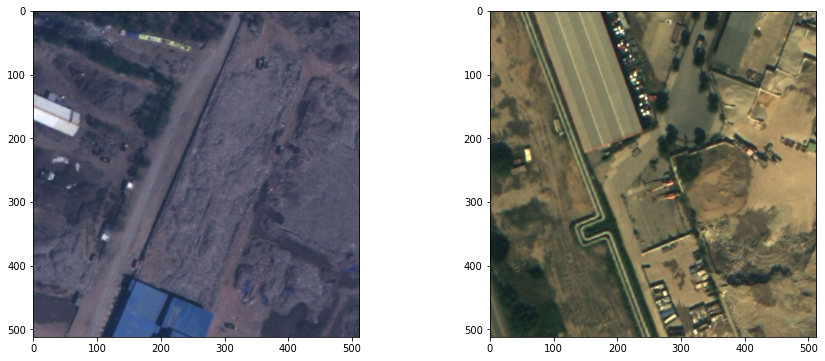

In [8]:
fig, ax = plt.subplots(1,2, figsize = (15, 6))
rgb4 = four_channel_img.data[[2,1,0]].transpose(1,2,0)/1000
rgb8 = eight_channel_img.data[[4,2,1]].transpose(1,2,0)/1000
ax[0].imshow(rgb4.clip(min=0, max=1))
ax[1].imshow(rgb8.clip(min=0, max=1))

In [9]:
four_channel_img.coords['band'].values

array([1, 2, 3, 4])

In [10]:
four_channel_img.transpose('band', 'y', 'x').sel(band=[4, 1, 2, 3])

<xarray.DataArray (band: 4, y: 512, x: 512)>
array([[[316, 302, ..., 529, 535],
        [316, 307, ..., 553, 562],
        ...,
        [656, 662, ..., 357, 371],
        [635, 648, ..., 381, 393]],

       [[259, 250, ..., 409, 410],
        [266, 262, ..., 428, 431],
        ...,
        [464, 466, ..., 339, 344],
        [450, 456, ..., 352, 353]],

       [[181, 172, ..., 345, 343],
        [182, 175, ..., 369, 368],
        ...,
        [398, 399, ..., 248, 254],
        [385, 391, ..., 263, 266]],

       [[160, 148, ..., 366, 364],
        [156, 148, ..., 394, 395],
        ...,
        [457, 460, ..., 227, 239],
        [442, 449, ..., 243, 252]]], dtype=uint16)
Coordinates:
  * band         (band) int64 4 1 2 3
  * x            (x) float64 2.491e+05 2.491e+05 ... 2.493e+05 2.493e+05
  * y            (y) float64 2.543e+06 2.543e+06 ... 2.542e+06 2.542e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [11]:
four_channel_img.band

<xarray.DataArray 'band' (band: 4)>
array([1, 2, 3, 4])
Coordinates:
  * band         (band) int64 1 2 3 4
    spatial_ref  int64 0

In [12]:
# adding channels to 4 channel tifs
def add_and_reorder_channels(sorted_tif, tif_path, img_path):
  
  """
  Transforms the Geoeye-1 Images into an 8 channel image with the addition of dummy channels

  Worldview-3 spectral bands (8 Channel)
  0 - coastal blue, 1 - blue, 2 - green, 3 - yellow
  4 - red, 5 - red edge, 6 - NIR1, 7 - NIR 2 

  Geoeye-1 Spectral Bands (4 Channel)
  0 - blue, 1 - green, 2 - red, 3 - NIR

  Geoeye-1 Spectral Bands Dummy Set (8 Channel)
  0 - zeros, 1 - blue, 2 - green, 3 - zeros
  4 - red, 5 - zeros, 6 - NIR, 7 - zeros
  """

  for tif_file in sorted_tif:

    raster = rioxarray.open_rasterio(f'{tif_path}{tif_file}')
    if np.shape(raster)[0] < 8:
      zeros = xr.DataArray((np.zeros((8 - (np.shape(raster)[0]), 512, 512))), 
                          dims=raster.dims,
                          coords=raster.coords, 
                          attrs=raster.attrs)
      img = xr.concat([raster, zeros], dim='band')
      new_bands = xr.IndexVariable('band', range(1, len(img.band) + 1)) # resets the band index
      imgc = img.assign_coords(band=new_bands)
      imgt = imgc.transpose('band', 'y', 'x').sel(band=[4, 1, 2, 5, 3, 6, 7, 8]) # reorders the channels to match the 8 channel WV3 satellite
    imgt.rio.to_raster(raster_path=f'{img_path}{tif_file}')

mask_to_raster(sorted_train_json, sorted_train_tif, train_json_path, train_tif_path, train_msks_path)
mask_to_raster(sorted_valid_json, sorted_valid_tif, valid_json_path, valid_tif_path, valid_msks_path)
add_and_reorder_channels(sorted_train_tif, train_tif_path, train_imgs_path)
add_and_reorder_channels(sorted_valid_tif, valid_tif_path, valid_imgs_path)

Test the reordering of the channels

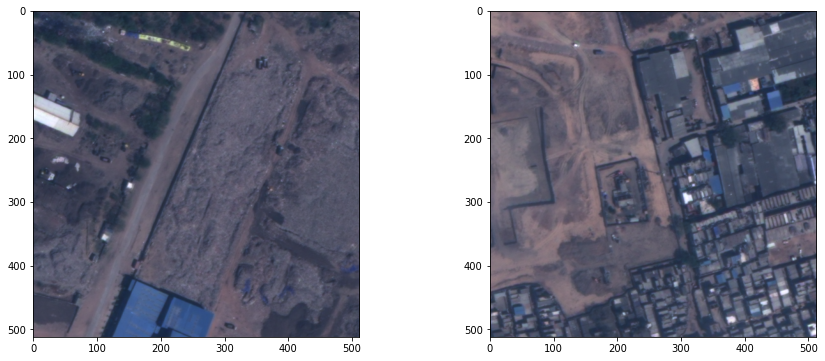

In [13]:
four_channel_img = rioxarray.open_rasterio(f'./{train_imgs_path}/{four_channel[0]}')
eight_channel_img = rioxarray.open_rasterio(f'./{train_imgs_path}/{eight_channel[0]}')

fig, ax = plt.subplots(1,2, figsize = (15, 6))
rgb4 = four_channel_img.data[[4,2,1]].transpose(1,2,0)/1000
rgb8 = eight_channel_img.data[[4,2,1]].transpose(1,2,0)/1000
ax[0].imshow(rgb4.clip(min=0, max=1))
ax[1].imshow(rgb8.clip(min=0, max=1))

### Model

In [14]:
os.getcwd()
root = Path('drive')
assert root.exists()

train_imgs_path = Path('./TrainingImages/')
train_msks_path = Path('./TrainingMask')
valid_imgs_path = Path('./ValidationImages')
valid_msks_path = Path('./ValidationMask')

train_imgs = list((train_imgs_path).glob('*.tif'))
train_msks = list((train_msks_path).glob('*.tif'))
valid_imgs = list((valid_imgs_path).glob('*.tif'))
valid_msks = list((valid_msks_path).glob('*.tif'))
print(len(train_imgs), len(train_msks), len(valid_imgs), len(valid_msks))

def scale_image(item: dict):
  '''
  scales the image to between 0 and 1
  '''
  item['image'] = item['image'] / 1000
  return item

218 218 24 24


In [15]:
from torchgeo.datasets import RasterDataset
train_imgs = RasterDataset(root = (train_imgs_path).as_posix(), transforms=scale_image, crs='epsg:3395', res=0.3)
train_msks = RasterDataset(root = (train_msks_path).as_posix(), crs='epsg:3395', res=1) # res is the spatial resolution of the image (i.e. msk.crs.linear_units)
valid_imgs = RasterDataset(root = (valid_imgs_path).as_posix(), transforms=scale_image, crs='epsg:3395', res=0.3)
valid_msks = RasterDataset(root = (valid_msks_path).as_posix(), crs='epsg:3395', res=1) # res is the spatial resolution of the image (i.e. msk.crs.linear_units)


train_msks.is_image = False # makes sure the train_msks dataset is added as a mask tensor
valid_msks.is_image = False

# combines the images and masks into a single dataset
train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks


from torchgeo.samplers import RandomGeoSampler, Units
train_sampler = RandomGeoSampler(train_imgs, size=256, length=100, units=Units.PIXELS) # extracts 256x256 parts of the image - can work on any size image larger than this
valid_sampler = RandomGeoSampler(valid_imgs, size=256, length=10, units=Units.PIXELS)

Converting RasterDataset resolution from 1 to 0.3
Converting RasterDataset resolution from 1 to 0.3


In [16]:
sample = next(iter(train_sampler))
img_sample = train_imgs[sample]
msk_sample = train_msks[sample]
train_sample = train_dset[sample]

print(train_sample.keys())
print(train_sample['image'].shape, train_sample['mask'].shape)

from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=8, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size=8, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))

print(train_batch.keys())
print(train_batch['image'].shape, train_batch['mask'].shape)

dict_keys(['crs', 'bbox', 'image', 'mask'])
torch.Size([8, 256, 256]) torch.Size([1, 256, 256])
dict_keys(['crs', 'bbox', 'image', 'mask'])
torch.Size([8, 8, 256, 256]) torch.Size([8, 1, 256, 256])


In [17]:
from typing import Iterable, List
import torchgeo

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [4,2,1], bright: float = 1.):
  for img, ax in zip(images, axs):
    arr = torch.clamp(bright * img, min=0, max=1).numpy()
    rgb = arr.transpose(1, 2, 0)[:, :, chnls]
    ax.imshow(rgb)
    ax.axis('off')

def plot_msks(masks: Iterable, axs: Iterable):
  for mask, ax in zip(masks, axs):
    ax.imshow(mask.squeeze().numpy(), cmap='Blues')
    ax.axis('off')

def plot_batch(batch: dict, bright: float = 1., cols: int = 4, width: int = 5, chnls: List[int] = [4,2,1]):

  # get the samples and the number of items in the batch
  samples = unbind_samples(batch.copy())

  # if batch contains images and masks, the number of images will be doubled
  n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

  # calculate the number of rows in the grid
  rows = n//cols + (1 if n%cols != 0 else 0)

  # create a grid
  _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))

  if ('image' in batch) and ('mask' in batch):
    # plot the images on the even axis
    plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright)
    #plot the masks on the odd axis
    plot_msks(masks=map(lambda x:x['mask'], samples), axs=axs.reshape(-1)[1::2])
  
  else:
    if 'image' in batch:
      plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright)
    
    elif 'mask' in batch:
      plot_msks(masks=map(lambda x: x['image'], samples), axs=axs.reshape(-1))

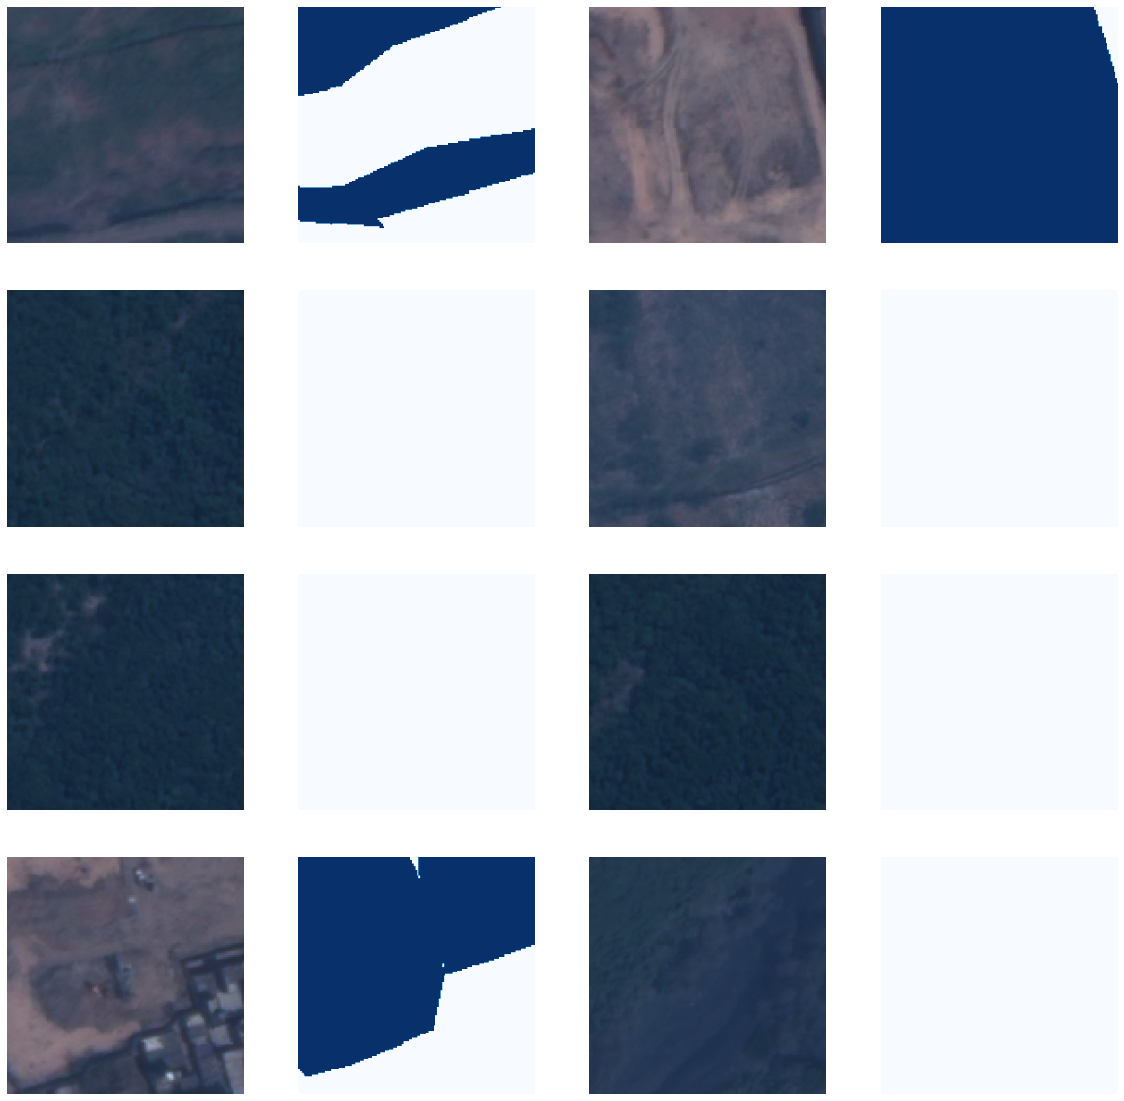

In [18]:
plot_batch(train_batch).savefig()

In [19]:
train_batch['image'][0]

tensor([[[0.4830, 0.4830, 0.4890,  ..., 0.5560, 0.5560, 0.5560],
         [0.4830, 0.4830, 0.4890,  ..., 0.5560, 0.5560, 0.5560],
         [0.4920, 0.4920, 0.4890,  ..., 0.5630, 0.5650, 0.5650],
         ...,
         [0.4520, 0.4520, 0.4590,  ..., 0.4430, 0.4500, 0.4500],
         [0.4630, 0.4630, 0.4670,  ..., 0.4260, 0.4290, 0.4290],
         [0.4630, 0.4630, 0.4670,  ..., 0.4260, 0.4290, 0.4290]],

        [[0.3690, 0.3690, 0.3760,  ..., 0.3340, 0.3330, 0.3330],
         [0.3690, 0.3690, 0.3760,  ..., 0.3340, 0.3330, 0.3330],
         [0.3640, 0.3640, 0.3650,  ..., 0.3350, 0.3350, 0.3350],
         ...,
         [0.3330, 0.3330, 0.3350,  ..., 0.3170, 0.3230, 0.3230],
         [0.3390, 0.3390, 0.3420,  ..., 0.3110, 0.3150, 0.3150],
         [0.3390, 0.3390, 0.3420,  ..., 0.3110, 0.3150, 0.3150]],

        [[0.2890, 0.2890, 0.2970,  ..., 0.2680, 0.2680, 0.2680],
         [0.2890, 0.2890, 0.2970,  ..., 0.2680, 0.2680, 0.2680],
         [0.2860, 0.2860, 0.2870,  ..., 0.2710, 0.2710, 0.

In [27]:
def calc_statistics(dset: RasterDataset):
        
        """
        Calculate the statistics (mean and std) for the entire dataset
        Warning: This is an approximation. The correct value should take into account the
        mean for the whole dataset for computing individual stds
        """

        # to avoid loading the entire dataset in memory, we will loop through each img
        # the filenames will be retrieved from the dataset's rtree index
        files = [item.object for item in dset.index.intersection(dset.index.bounds, objects=True)]

        # reseting statistics
        accum_mean = 0
        accum_std = 0

        for file in files:
            img = rasterio.open(file).read()/10000 #type: ignore
            accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
            accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

        # at the end, we shall have 2 vectors with lenght n=chnls
        # we will average them considering the number of images
        return accum_mean / len(files), accum_std / len(files)

class Normalise(torch.nn.Module):
    """
    A custom normalization module that normalizes the input image by subtracting the mean and dividing by the standard deviation.
    Attributes:
        mean (torch.Tensor): A tensor of shape [C, 1, 1] containing the mean values for each channel.
        std (torch.Tensor): A tensor of shape [C, 1, 1] containing the standard deviation values for each channel.
    """
    def __init__(self, mean: List[float], stdev: List[float]):
        """
        Initialize the module with the given mean and standard deviation values.
        Args:
            mean (List[float]): A list of floats containing the mean values for each channel.
            stdev (List[float]): A list of floats containing the standard deviation values for each channel.
        """

        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):
        """
        Normalize the input image by subtracting the mean and dividing by the standard deviation.
        Args:
            inputs (dict): A dictionary with the 'image' key containing a tensor of shape [N, C, H, W] or [C, H, W].
        Returns:
            dict: The same dictionary with the normalized image in the 'image' key.
        """
        
        x = inputs["image"][..., : len(self.mean), :, :]
        if inputs["image"].ndim == 4: # if batch
            x = (x - self.mean[None, ...]) / self.std[None, ...]
        else:
            x = (x - self.mean) / self.std
            
        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalise the input image by multiplying by the standard deviation and adding the mean.
        Args:
            inputs (dict): A dictionary with the 'image' key containing a tensor of shape [N, C, H, W] or [C, H, W].
        Returns:
            dict: The same dictionary with the de-normalised image in the 'image' key.
        """
        
        x = inputs["image"][..., : len(self.mean), :, :]
        if x.ndim == 4: # if batch
            x = inputs["image"][:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

# def normalise(x: np.ndarray, scale: float = 2000) -> np.ndarray:
#     """min/max normalise to [0, 1] range given a scale."""
#     return np.clip(x / scale, 0, 1)


In [21]:
# X = train_batch.read()
# norm_batch = normalise(X).astype(np.float32)
# norm_batch = torch.from_numpy(norm_batch)


AttributeError: ignored

In [23]:
# from torchgeo.transforms import indices
# ndwi_transform = indices.AppendNDWI(index_green=1, index_nir=3)
# transformed_batch = ndwi_transform(norm_batch)

NameError: ignored

In [28]:
from torch import nn

# creates a normalisation transformation for a PyTorch dataset by calculating the mean and standard deviation for each channel across all images in the training dataset and then using those values to instantiate a Normalise object
normalise = Normalise(*calc_statistics(train_imgs))
tfms = torch.nn.Sequential(
    # ndwi_transform
    # ndvi_transform
    normalise #  instance is wrapped in a PyTorch Sequential container and assigned to the variable tfms
)

In [25]:
from torchvision.models.segmentation import deeplabv3_resnet50
dlabv3 = deeplabv3_resnet50(weights=None, num_classes=2) # imports the pre-trained deeplabv3 model and initialises it with 2 output classes

backbone = dlabv3.get_submodule('backbone') # gets the backbone submodule of deeplabv3

conv = nn.modules.conv.Conv2d(
    in_channels=8, 
    out_channels=64, 
    kernel_size=(7, 7), 
    stride=(2, 2), 
    padding=(3, 3), 
    bias=False 
) # creates a 2D convolutional layer with 8 input channels, 64 output channels, a kernel size of 7x7, stride of 2x2, padding of 3x3 and no bias
backbone.register_module('conv1', conv) # registers the conv layer as the first layer of the backbone submodule

pred = dlabv3(torch.randn(8, 8, 256, 256)) # generates a prediction using the modified deeplabv3 model by passing a random tensor as input
pred['out'].shape # prints the shape of the 'out' key in the prediction dictionary

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([8, 2, 256, 256])

In [29]:
def train_loop(
    epochs: int, # number of epochs to train the model for
    train_dl: DataLoader, # dataloader for the training dataset
    val_dl: Optional[DataLoader], # dataloader for the validation dataset (default=None)
    model: nn.Module, # neural network model to train
    loss_fn: Callable, # loss function to use for optimization
    optimizer: torch.optim.Optimizer, # optimizer to use for training
    acc_fns: Optional[List]=None, # list of accuracy functions to use for evaluation (default=None)
    batch_tfms: Optional[Callable]=None # batch transform function to apply to each batch of data before passing it through the model (default=None)
):

    '''
    Trains a PyTorch model for a specified number of epochs using a specified optimizer and loss function. 
    Optionally evaluates the model on a validation dataset using specified accuracy metrics. 
    Can also apply transformations to the input batches using a specified callable.

    Returns: None
    '''

    # size = len(dataloader.dataset)
    cuda_model = dlabv3.cuda() # move the model to GPU

    for epoch in range(epochs): # loop over number of epochs
        accum_loss = 0 # initialise the accumulated loss for the epochs
        for batch in train_dl: # loop over the batches in the training dataloader

            if batch_tfms is not None: # apply batch transformations if specified
                batch = batch_tfms(batch)

            X = batch['image'].cuda() # get the input batch and move to GPU
            y = batch['mask'].type(torch.long).cuda() # get the label batch and move to the GPU

            pred = cuda_model(X)['out'] # forward pass the input batch through the model to get the predicted output
            loss = loss_fn(pred, y) # compute the loss between the predicted output and the target tensor

            # backpropagration
            optimizer.zero_grad() # zero out the gradients from the previous iteration
            optimizer.step() # compute the gradients for the current iteration

            # update the accumalated loss for the epoch
            accum_loss += float(loss) / len(train_dl)

        # test against the validation dataset
        if acc_fns is not None and val_dl is not None: # if validation dataloader and accuracy functions are specified, test the model on the validation dataset
            acc = [0.] * len(acc_fns) # initialise the accuracy metrics

            with torch.no_grad(): # disable gradient computation for the validation pass
                for batch in val_dl: # loop over the batches in the validation datalaoder

                    if batch_tfms is not None: # apply batch transforms if specified
                        batch = batch_tfms(batch)                    

                    X = batch['image'].type(torch.float32).cuda() # get the input batch and move to GPU
                    y = batch['mask'].type(torch.long).cuda() # get the label batch and move to GPU

                    pred = cuda_model(X)['out'] # make predictions using the model

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl)) # calculate the accuracy metrics

            # print the epoch number, training loss, and accuracy metrics
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Accs={[round(a, 3) for a in acc]}')
        else:

            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

In [30]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
  '''
  Computes the overall accuracy of the model's predictions
  Args:
      pred (torch.Tensor): The predicted output tensor from the model
      y (torch.Tensor): The true label tensor
  Returns:
      torch.Tensor: The overall accuracy of the model's predictions
  '''
  flat_y = y.squeeze() # squeezes y tensor to flatten it to a 1D tensor
  flat_pred = pred.argmax(dim=1) # computes the predicted output by taking the argmax (index of maxima) of 'pred' tensor along dimension 1. 
  acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y) # calculates the overall accuracy of the models predictions 
  return acc

def iou(pred, y):
  '''
  Computes the Intersection over Union (IoU) score of the model's predictions
  Args:
      pred (torch.Tensor): The predicted output tensor from the model
      y (torch.Tensor): The true label tensor
  Returns:
      float: The IoU score of the model's predictions
  '''
  flat_y = y.cpu().numpy().squeeze() # squeezes y tensor to flatten it to a 1D tensor and converts to numpy array
  flat_pred = pred.argmax(dim=1).detach().cpu().numpy() # computes the predicted output by taking the argmax of the 'pred' tensor along dimension 1 and detaches it from the computation graph and converts it to a numpy array
  return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.) #  calculates the iou score of the model's predictions using the Jaccard similarity coefficient of the two flattened arrays

def loss(p, t):
  '''
  Computes the cross-entropy loss between the predicted output and the true labels.

  Args:
      p (torch.Tensor): The predicted output tensor from the model.
      t (torch.Tensor): The true label tensor.

  Returns:
      torch.Tensor: The cross-entropy loss between the predicted output and the true labels.
  '''
  return torch.nn.functional.cross_entropy(p, t.squeeze()) # applies the softmax activation function to the p tensor before computing the cross-entropy loss

In [31]:
optimizer = torch.optim.Adam(dlabv3.parameters(), lr=0.001, weight_decay=0.01)
train_loop(40, train_dataloader, valid_dataloader, dlabv3, loss, optimizer, 
           acc_fns=[oa, iou])

Epoch 0: Train Loss=0.73132 - Accs=[0.527, 0.422]
Epoch 1: Train Loss=0.73086 - Accs=[0.537, 0.382]
Epoch 2: Train Loss=0.73122 - Accs=[0.511, 0.396]
Epoch 3: Train Loss=0.72991 - Accs=[0.413, 0.102]
Epoch 4: Train Loss=0.72008 - Accs=[0.49, 0.326]
Epoch 5: Train Loss=0.72242 - Accs=[0.496, 0.342]
Epoch 6: Train Loss=0.74102 - Accs=[0.572, 0.391]
Epoch 7: Train Loss=0.72797 - Accs=[0.481, 0.349]
Epoch 8: Train Loss=0.72749 - Accs=[0.56, 0.485]
Epoch 9: Train Loss=0.73067 - Accs=[0.464, 0.361]
Epoch 10: Train Loss=0.73210 - Accs=[0.479, 0.331]
Epoch 11: Train Loss=0.72980 - Accs=[0.416, 0.272]
Epoch 12: Train Loss=0.72831 - Accs=[0.412, 0.276]
Epoch 13: Train Loss=0.72825 - Accs=[0.447, 0.213]
Epoch 14: Train Loss=0.72824 - Accs=[0.555, 0.349]
Epoch 15: Train Loss=0.72976 - Accs=[0.409, 0.249]
Epoch 16: Train Loss=0.72857 - Accs=[0.527, 0.429]
Epoch 17: Train Loss=0.73254 - Accs=[0.467, 0.182]
Epoch 18: Train Loss=0.72900 - Accs=[0.504, 0.382]
Epoch 19: Train Loss=0.73065 - Accs=[0.493,

In [1]:
# dlabv3.eval() # set the model to evaluation mode

# val_loss = 0.0
# val_accs = [0.0] * len(oa)

# with torch.no_grad(): # disable gradient computation for the validation pass
#     for batch in valid_dataloader: # loop over the batches in the validation datalaoder
#         if batch_tfms is not None: # apply batch transforms if specified
#             batch = batch_tfms(batch)                    

#         X = batch['image'].type(torch.float32).cuda() # get the input batch and move to GPU
#         y = batch['mask'].type(torch.long).cuda() # get the label batch and move to GPU

#         pred = dlabv3(X)['out'] # make predictions using the model

#         batch_loss = loss(pred, y) # compute the loss between the predicted output and the target tensor
#         val_loss += float(batch_loss) / len(valid_dataloader)

#         for i, acc_fn in enumerate(oa):
#             val_accs[i] += float(acc_fn(pred, y))/len(valid_dataloader) # calculate the accuracy metrics

# # print the validation loss and accuracy metrics
# print(f'Validation Loss={val_loss:.5f} - Accs={[round(a, 3) for a in val_accs]}')


### References

https://www.dropbox.com/sh/4hhtqy35vtape6w/AAC7tDK01n3iwlwAuGFWPDIra/thesis_MSc_Anupama_Rajkumar.pdf?dl=0

https://towardsdatascience.com/introducing-a-very-high-resolution-dataset-of-landfills-and-waste-dumps-196d46d533fc

https://towardsdatascience.com/artificial-intelligence-for-geospatial-analysis-with-pytorchs-torchgeo-part-1-52d17e409f09

https://towardsdatascience.com/artificial-intelligence-for-geospatial-analysis-with-pytorchs-torchgeo-part-2-ec3785fae284

https://towardsdatascience.com/artificial-intelligence-for-geospatial-analysis-with-pytorchs-torchgeo-part-3-7521131f30b1